# Chapitre 6 - Différentes utilisations du machine learning avec Python (2ème partie)

## 6.5 L’apprentissage non supervisé

### 6.5.2 Implémentation d’une méthode de clustering avec Python*

Dans le cas d’un clustering les données consiste en un bloc de variables x
desquelles on va extraire des groupes d’observations en utilisant une méthode plus
ou moins similaire.

Nous allons appliquer les k-means directement sur les données. Les k-means
(k-moyennes) sont donc un algorithme d’apprentissage non supervisé permettant
de construire des classes d’observations à partir d’un jeu de données de grande
dimension.

Cet algorithme est un algorithme itératif qui va partir de points choisis aléatoirement
et qui va calculer des proximités afin d’associer de nouveaux points à la classe.
À chaque étape, le centre de chaque classe est modifié ce qui va impacter les individus
sélectionnés dans chaque classe.

#### Préparation des données

Les données que nous utilisons sont des données sur les communes d’Île-de-
France et leur caractéristiques socio-démographiques. 

Notre objectif est ici de comprendre s’il existe des classes de communes ayant des caractéristiques proches.
On obtiendra ainsi une typologie des communes d’Île-de-France et on pourra représenter
ces groupes sur une carte.

Nous allons préparer ces données qui sont disponibles sur le site du livre. Une
description est disponible au début du chapitre 4.m

In [1]:
import pandas as pd
import numpy as np
# on récupère le fichier csv
data=pd.read_csv("../Data/base-comparateur-de-territoires.csv",sep=";")
# on enlève des variables avec trop de données manquantes
data.drop(["PIMP14","TP6014"],axis=1,inplace=True)
# on enlève les observations avec des données manquantes
data.dropna(inplace=True)
# on extrait dans un DataFrame la position géographique des comunes
position=pd.DataFrame(data["geo_point_2d"])
# on crée une colonne longitude en prenant la première partie
# de la colonne geo_point_2
position["longitude"]=pd.to_numeric(position["geo_point_2d"].str.split(',')\
                                    .str.get(0))
# on fait la même chose pour la latitude
position["latitude"]=pd.to_numeric(position["geo_point_2d"].str.split(',')\
                                   .str.get(1))


# finalement, on sélectionne uniquement les données numériques
# pour faire notre K-means et on enlève trois variables inutiles
x=data.select_dtypes(np.number).drop(["CODGEO","REG","DEP"],axis=1)

#### Validation du modèle et choix du nombre de classes
Dans le cas du clustering, il est très difficile de valider le modèle avec des indicateurs
statistiques. En effet, on ne peut pas tester la qualité prédictive. Nous allons
essayer de faire en sorte d’obtenir des classes les plus homogènes possibles et de
minimiser l’inertie. 

Afin de choisir le nombre de classe à utiliser on peut utiliser un
graphique. Elle représente l’inertie par nombre de classes. On recherche un coude
dans cette courbe pour décider le nombre à retenir.

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
# on crée une liste dans laquelle on stocke les inerties
inerties=[]
# on fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in range(2, 10):
    # pour chaque k, on crée un modèle et on l’ajuste
    kmeans=KMeans(n_clusters=k,n_init='auto')
    kmeans.fit(x)
    # on stocke l’inertie associée
    inerties.append(kmeans.inertia_)

Text(0.5, 1.0, 'Inertie vs nombre de classes')

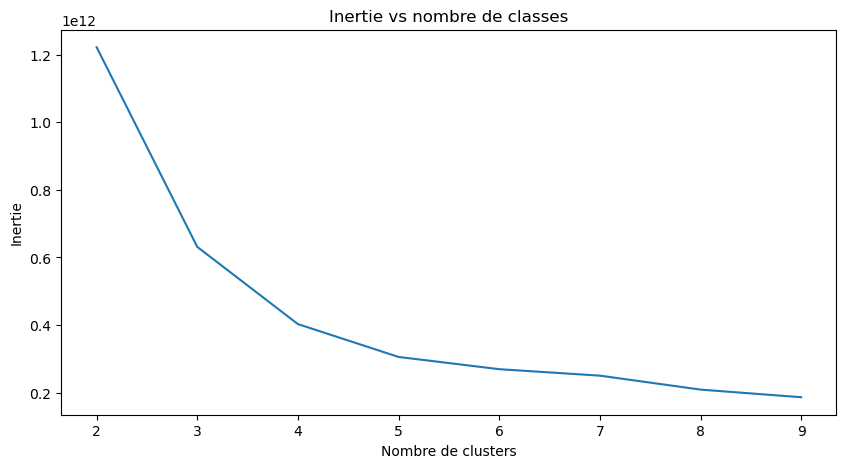

In [4]:
# on représente le graphique
fig=plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), inerties)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title('Inertie vs nombre de classes')

#### Application des k-means
Pour appliquer les k-means sur nos données, on utilisera :

In [5]:
from sklearn.cluster import KMeans
modele_km=KMeans(n_clusters=4, n_init="auto")
modele_km.fit(x)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [6]:
# on stocke les classes d’appartenance dans classes
classes=modele_km.labels_
# on crée un DataFrame avec le nombre d’individus par calsse
count=pd.DataFrame(np.unique(classes,return_counts=True)[1],
columns=["Nombre d’individus"])
# on stocke les centres des classes dans un DataFrame
centres=pd.DataFrame(modele_km.cluster_centers_,columns=x.columns)

print(pd.concat([count,pd.DataFrame(centres,columns=x.columns)],axis=1).T.head())

                              0            1             2           3
Nombre d’individus  1063.000000     32.00000    172.000000      10.000
P14_POP             2520.139229  75067.59375  30048.715116  177206.800
P09_POP             2438.517404  73660.68750  29077.122093  177166.400
SUPERF                 9.483584      8.28625      8.591453       8.208
NAIS0914             157.023518   6120.00000   2467.558140   12244.800


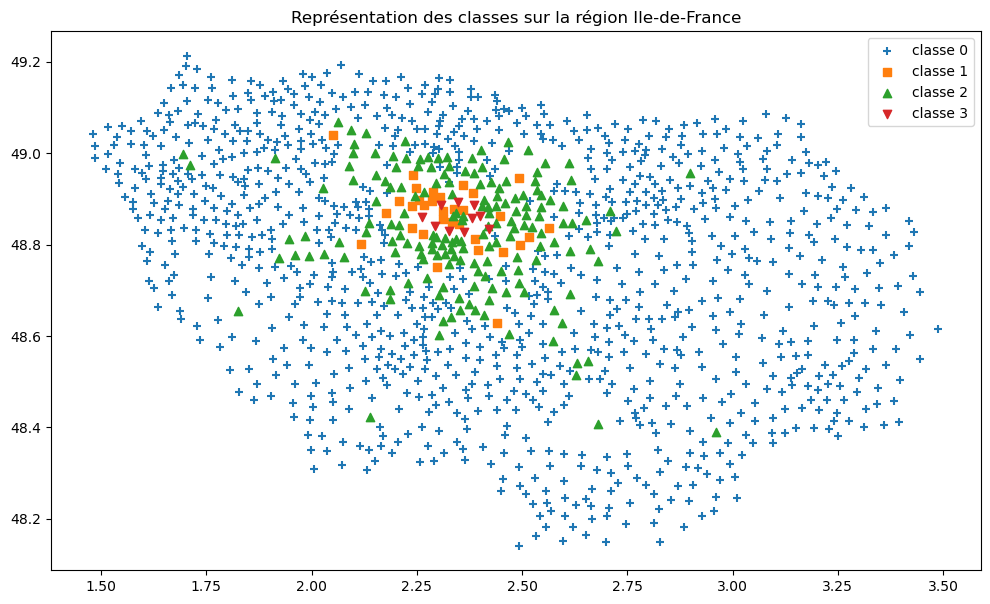

In [7]:
# on crée une figure
plt.figure(figsize=(12,7))
# on fait une boucle sur les classes en définissant des marqueurs par classe
markers=["+","s","^","v"]
for val, mark in zip(np.unique(classes),markers):
    plt.scatter(position["latitude"][classes==val],
                position["longitude"][classes==val], marker=mark,
                label="classe% i"%(val))
plt.title("Représentation des classes sur la région Ile-de-France")
plt.legend()

On voit que les quatre classes se répartissent très bien sur l’Ile-de-France avec :
- Classe 0 : petites communes éloignées de Paris
- Classe 1 : grandes communes de la petite ceinture
- Classe 2 : arrondissements extérieurs de Paris (12 à 20)
- Classe 3 : communes moyennes moins proches de Paris

On pourrait bien entendu ajouter un fond de carte comme nous l’avons fait dans
le chapitre 5.

#### Les mélanges gaussiens

Une méthode moins connue et alternative au k-means se nomme mélanges gaussiens.
Son principe est simple : on suppose que les données sur lesquelles nous
travaillons sont issues de plusieurs populations suivant des lois gaussiennes multivariées.
On va donc essayer d’extraire les populations en utilisant un algorithme EM
(expectation maximisation). Celui-ci utilise en plus de la moyenne et de la variance (ce
qui est le cas des k-means), les structures de covariances. De plus, l’appartenance à
une classe devient probabiliste.

Les mélanges gaussiens peuvent être aussi appliqués dans un cadre supervisé
mais nous l’utilisons ici en non supervisé :

In [8]:
from sklearn.mixture import GaussianMixture
modele_gmm=GaussianMixture(n_components=4)
modele_gmm.fit(x)

,n_components,4
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


Nous allons obtenir des classes et des moyennes par classes :

In [9]:
# on stocke les classes d’appartenance dans classes
classes=modele_gmm.predict(x)

# on crée un DataFrame avec le nombre d’individus par calsse
count=pd.DataFrame(np.unique(classes,return_counts=True)[1],
                   columns=["Nombre d’individus"])

# on stocke les centres des classes dans un DataFrame
centres=pd.DataFrame(modele_gmm.means_,columns=x.columns)


print(pd.concat([count,pd.DataFrame(centres,columns=x.columns)],axis=1).T.head())


                             0           1            2             3
Nombre d’individus  695.000000      10.000   422.000000    150.000000
P14_POP             759.418574  177206.800  8184.410042  41818.011272
P09_POP             739.144838  177166.400  7926.792149  40642.842338
SUPERF                9.753488       8.208     9.491666      6.932234
NAIS0914             41.215315   12244.800   554.029057   3499.771564


On voit ici que notre méthode a mieux réparti les individus par classe. On a toujours une répartition qui peut être interprétée :

- Classe 0 : Petites communes en termes de population
- Classe 1 : Très grandes communes en termes de population avec une superficie moyenne. Il s’agit ici des arrondissements 11 à 20 de Paris.
- Classe 2 : Communes de taille moyenne éloignées du centre de Paris.
- Classe 3 : Communes denses plutôt en petite ceinture.

### 6.6.2 Les méthodes de réduction de dimension

Parmi les algorithmes non supervisés, on inclut souvent des méthodes qui permettent de réduire le nombre de dimensions de vos données. Nous allons présenter
l’utilisation de trois d’entre elles : l’analyse en composantes principales et deux
méthodes non linéaires.

Les méthodes de réduction de dimensions se divisent en deux familles : les
méthodes linéaires et les méthodes non linéaires.

#### Méthodes linéaires
Il s’agit de méthodes d’analyse de données souvent bien connues. On pourra citer :

- l’analyse en composantes principales (ACP/PCA)
- l’analyse en composantes indépendantes
- la décomposition en valeurs singulières
- l’analyse factorielle
- les analyses multi-tableaux

Et pour des données qualitatives :
   
- l’analyse des correspondances multiples

Scikit-Learn possède de nombreuses approches mais nous allons nous concentrer sur une application de l’analyse en composantes principales.

#### Application de l'ACP
Nous utilisons une base de données d’images : celle du jeu de données Fashion-
MNIST qui rassemble des photographies de vêtements (un vêtement par image).
Ces données sont directement disponibles dans le package Keras. Nous allons utiliser l’ACP pour réduire la complexité de ces images. 

Une description des données est disponible au début du chapitre 4.

In [2]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
# on récupère les données dans 4 arrays
(train_img, train_lbl), (test_img, test_lbl)=fashion_mnist.load_data()
# ce jeu de données d’apprentissage est composé de 600000 images
# ayant 28 x 28 pixels en noir et blanc
train_img.shape

In [ ]:
# l’image 801 a le label 9: chaussure
train_lbl[800]

In [ ]:
plt.imshow(train_img[800])

Nous avons donc récupéré des images de taille 28 par 28 qui sont stockées dans
un array avec une image par ligne.

L’objectif est de réduire le nombre d’informations nécessaires à l’apprentissage de ces images en vue d’appliquer un modèle prédictif. Nous allons voir comment simplifier ces images en utilisant toutes les données :

In [ ]:
# on passe les images en deux dimensions
img_acp=train_img.reshape(train_img.shape[0],-1)

# on crée un modèle d’ACP
pca=PCA(n_components=.80)

# on réduit le nombre de dimensions avec l’ACP
donnees_reduites=pca.fit_transform(img_acp)

# Pour capturer 80% de l’information, on utiliser 43 des 784 composantes
# on projette les données réduites dans l’espace d’origine
projection=pca.inverse_transform(donnees_reduites)

In [ ]:
# on affiche les résultats
plt.figure(figsize=(8,4));
# image initale
plt.subplot(1, 2, 1);
plt.imshow(img_acp[22000].reshape(28,28))
plt.xlabel('%i composantes'%(img_acp.shape[1]))
plt.title('Image initiale');
# image basée sur l’ACP
plt.subplot(1, 2, 2);
plt.imshow(projection[22000].reshape(28, 28))
plt.xlabel('%i composantes' %(donnees_reduites.shape[1]))
plt.title('%s de variance expliquée'%(str(pca.n_components*100)+"%"))

#### Méthodes non linéaires
Dans le cas de l’ACP, nous réduisons l’espace des données vers un espace de
dimension plus petit avec une transformation linéaire. Parfois cela ne suffit pas ou n’est pas adapté aux données. Par exemple, si vos données sont distribuées selon une forme géométrique multivariée, il faudra une transformation non linéaire pour extraire le plus d’informations possible.

Nous allons utiliser les algorithmes Isomap et t-SNE qui sont deux approches du
manifold learning :

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn import datasets

In [ ]:
# génération des données
n_points = 1000
X, color = datasets.make_swiss_roll(n_points)
n_neighbors = 10
n_components = 2

In [ ]:
# projection vers un espace à deux dimensions
x_acp = PCA(n_components).fit_transform(X)
x_iso = Isomap(n_neighbors=n_neighbors, n_components=n_components).fit_transform(X)
x_tsne = TSNE(n_components).fit_transform(X)

In [ ]:
# on construit la figure comparative
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(131)
plt.title("ACP")
plt.scatter(x_acp[:, 0], x_acp[:, 1], c=color, s=8)
ax = fig.add_subplot(132)
plt.title("IsoMap")
plt.scatter(x_iso[:, 0], x_iso[:, 1], c=color, s=8)
ax = fig.add_subplot(133)
plt.title("tSNE")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=color, s=8)

Ces graphiques permettent de visualiser les résultats d’une
réduction à deux dimensions en fonction des algorithmes. Le résultat obtenu par
l’ACP ne va pas permettre de trouver ensuite des séparations simples dans les
données IsoMap réussit à garder la distance entre les points tels qu’ils étaient sur
la spirale.

### Aller plus loin

De nombreuses autres méthodes de machine learning non supervisé sont disponibles. La documentation de scikit-learn vous aidera à en avoir un aperçu très lare :
    
- Clustering : 

http://scikit-learn.org/stable/modules/clustering.html#clustering


- Réduction de dimension : 

http://scikit-learn.org/stable/modules/decomposition.html#decompositions